In [267]:
import faiss
import matplotlib
import numpy as np
import random
import dill
import os
import sys
import collections
import torch
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from fastprogress.fastprogress import progress_bar
from PIL import Image

module_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src.constants import VGGFACE2_CONFIGS_PATH, VGGFACE2_DATASET_PATH
from src.helpers.vggface2_utils import get_individuals_in_dataset, get_images_in_folder
from src.helpers.utils import read_and_convert_rgb
from src.isc2021_eval.isc2021_metrics import find_operating_point

In [349]:
sp_models = [
    '../../src/models/trained_models/yokoo/single-purpose-1m-9/',
    '../../src/models/trained_models/yokoo/single-purpose-1m-99/',
    '../../src/models/trained_models/yokoo/single-purpose-1m-999/',
    '../../src/models/trained_models/yokoo/single-purpose-1m-9999/',
    '../../src/models/trained_models/yokoo/single-purpose-1m-99999/',
    '../../src/models/trained_models/yokoo/single-purpose-1m-1/',
    '../../src/models/trained_models/yokoo/single-purpose-1m-12/',
    '../../src/models/trained_models/yokoo/single-purpose-1m-123/',
    '../../src/models/trained_models/yokoo/single-purpose-1m-1234/',
    '../../src/models/trained_models/yokoo/single-purpose-1m-12345/',
]

In [350]:
dp_models = [
    '../../src/models/trained_models/yokoo/dual-purpose-n000155-1m/',
    '../../src/models/trained_models/yokoo/dual-purpose-n002754-1m/',
    '../../src/models/trained_models/yokoo/dual-purpose-n003829-1m/',
    '../../src/models/trained_models/yokoo/dual-purpose-n004594-1m/',
    '../../src/models/trained_models/yokoo/dual-purpose-n004706-1m/',
    '../../src/models/trained_models/yokoo/dual-purpose-n005517-1m/',
    '../../src/models/trained_models/yokoo/dual-purpose-n006332-1m/',
    '../../src/models/trained_models/yokoo/dual-purpose-n006373-1m/',
    '../../src/models/trained_models/yokoo/dual-purpose-n006408-1m/',
    '../../src/models/trained_models/yokoo/dual-purpose-n009218-1m/'
]

In [351]:
def get_prec_rec_fpr_f1(metrics, key, target=False, non_target=False):
    if target:
        prec = np.asarray([metrics.target_precision[key] * 100])
        rec = np.asarray([metrics.target_recall[key] * 100])
        curr_fpr = [metrics.target_fpr[key] * 1e6]
    elif non_target:
        prec = np.asarray(metrics.non_target_precision) * 100
        rec = np.asarray(metrics.non_target_recall) * 100
        curr_fpr = np.asarray(metrics.non_target_fpr) * 1e6
    curr_f1 = (2 * prec * rec) / (prec + rec + 1e-6)
    return prec, rec, curr_f1, curr_fpr

In [352]:
def print_model_names(data_paths):
    for x in data_paths:
        print(os.path.basename(os.path.dirname(x)))

In [353]:
def print_median_iqr(metrics, titles):
    for metric, title in zip(metrics, titles):
        print(f"{title}: {np.median(metric)} $\pm$ {scipy.stats.iqr(metric)}")

# VGGFace2 and WebFace260m images

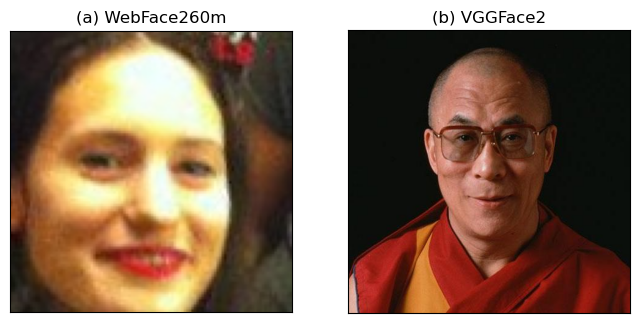

In [354]:
webface_image_path = '/data_2/shubham/WebFace260M/0/WebFace260M/0_0_0000000/0_2.jpg'
vggface2_image_path = '/data_2/shubham/vggface2/n000001/0084_01.jpg'
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axs[0].imshow(read_and_convert_rgb(webface_image_path))
axs[1].imshow(read_and_convert_rgb(vggface2_image_path))
axs[0].tick_params(left = False, right = False , labelleft = False ,
                   labelbottom = False, bottom = False)
axs[1].tick_params(left = False, right = False , labelleft = False ,
                   labelbottom = False, bottom = False)
axs[0].set_title('(a) WebFace260m')
axs[1].set_title('(b) VGGFace2')
plt.savefig('fr-datasets-images.pdf', bbox_inches='tight')
plt.show()

# VGGFace2 dataset before and after cleaning

In [355]:
mislabelled_data_path = os.path.join(VGGFACE2_CONFIGS_PATH, 'mislabelled_threshold_0.6.dill')
duplicates_data_path = os.path.join(VGGFACE2_CONFIGS_PATH, 'duplicates_threshold_1.0.dill')

with open(mislabelled_data_path, 'rb') as fp:
    mislabelled_data = dill.load(fp)

with open(duplicates_data_path, 'rb') as fp:
    duplicates_data = dill.load(fp)

individuals = get_individuals_in_dataset(VGGFACE2_DATASET_PATH)
total_images = {}
failed_images = {}
mislabelled_images = {}
duplicate_images = {}
remaining_images = {}

for ind in progress_bar(individuals):
    total_images[ind] = len(get_images_in_folder(os.path.join(VGGFACE2_DATASET_PATH, ind)))
    failed_images[ind] = len(mislabelled_data[ind]['failed_images'])
    mislabelled_images[ind] = len(mislabelled_data[ind]['suspected_images'])
    duplicate_images[ind] = len(duplicates_data[ind])
    remaining_images[ind] = total_images[ind] - failed_images[ind] - mislabelled_images[ind] - duplicate_images[ind]

opacity = 0.75
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axs[0].hist(total_images.values(), bins=50, label='Original VGGFace2 dataset', color=(*mcolors.to_rgb('tab:orange'), opacity))
axs[0].hist(remaining_images.values(), bins=50, label='Cleaned VGGFace2 dataset', color=(*mcolors.to_rgb('tab:blue'), opacity))
axs[0].set_title('(a)')
axs[0].set_xlabel('# Images per individual')
axs[0].set_ylabel('# Individuals')
axs[0].set_ylim((0, 850))
axs[0].legend()
axs[1].hist([remaining_images[ind] / total for ind, total in total_images.items()], bins=50)
axs[1].set_xlabel('Proportion of images remaining')
axs[1].set_title('(b)')
axs[1].set_ylim((0, 850))
plt.savefig('vggface2-dataset-analysis.pdf', bbox_inches='tight')
plt.show()

min_images = 150
final_image_set = [x for x in remaining_images.values() if x >= 150]
print(f'Images remaining: {sum(remaining_images.values())}, Images before: {sum(total_images.values())}')
print(f'Failed images: {sum(failed_images.values())}({sum(failed_images.values()) / sum(total_images.values()) :.4f}), '
      f'Mislabelled images: {sum(mislabelled_images.values())}, ({sum(mislabelled_images.values()) / sum(total_images.values()) :.4f})'
      f'Duplicate images: {sum(duplicate_images.values())}, ({sum(duplicate_images.values()) / sum(total_images.values()) :.4f})')
print(f'Valid individuals: {len(final_image_set)}, '
      f'Images remaining: {sum(final_image_set)}')

Images remaining: 2502718, Images before: 3311286
Failed images: 28561(0.0086), Mislabelled images: 121292, (0.0366)Duplicate images: 658715, (0.1989)
Valid individuals: 8514, Images remaining: 2428033


# Primary task performance

Single-purpose vs Dual-purpose

In [356]:
"""Analyse primary task performance."""
def get_primary_task_details(models_paths):
    data_paths = [f.path for m in models_paths for f in os.scandir(m) if 'isc2021_1000000' in f.name]
    print_model_names(data_paths)
    val_mu_ap = []
    test_mu_ap = []
    precision_ot = []
    recall_ot = []
    for path in progress_bar(data_paths):
        with open(path, 'rb') as fp:
            data = dill.load(fp)
            val_mu_ap.append(data['val_metrics'].average_precision * 100)
            test_mu_ap.append(data['test_metrics'].average_precision * 100)
            tot, rot, pot = find_operating_point(
                data['test_metrics'].thresholds,
                data['test_metrics'].recalls,
                data['test_metrics'].precisions,
                required_x = data['val_metrics'].threshold_at_p90
            )
            precision_ot.append(pot * 100)
            recall_ot.append(rot * 100)
    return test_mu_ap, precision_ot, recall_ot

In [357]:
mu_ap_sp, precision_sp, recall_sp = get_primary_task_details(sp_models)
mu_ap_dp, precision_dp, recall_dp = get_primary_task_details(dp_models)

single-purpose-1m-9
single-purpose-1m-99
single-purpose-1m-999
single-purpose-1m-9999
single-purpose-1m-99999
single-purpose-1m-1
single-purpose-1m-12
single-purpose-1m-123
single-purpose-1m-1234
single-purpose-1m-12345


dual-purpose-n000155-1m
dual-purpose-n002754-1m
dual-purpose-n003829-1m
dual-purpose-n004594-1m
dual-purpose-n004706-1m
dual-purpose-n005517-1m
dual-purpose-n006332-1m
dual-purpose-n006373-1m
dual-purpose-n006408-1m
dual-purpose-n009218-1m


In [358]:
labels = ['muAP', 'Precision', 'Recall']
metrics_sp = [mu_ap_sp, precision_sp, recall_sp]
metrics_dp = [mu_ap_dp, precision_dp, recall_dp]
print('Single-purpose model primary task performance')
print_median_iqr(metrics_sp, labels)
print('Dual-purpose model primary task performance')
print_median_iqr(metrics_dp, labels)

Single-purpose model primary task performance
muAP: 59.421935105210366 $\pm$ 0.370342590781533
Precision: 90.19801490322487 $\pm$ 0.8272004947035754
Recall: 49.46097025354362 $\pm$ 0.9433020562986627
Dual-purpose model primary task performance
muAP: 59.24456012350359 $\pm$ 0.5462279833870269
Precision: 90.69430575623082 $\pm$ 0.3637055746794573
Recall: 49.29127570373328 $\pm$ 0.9982032341784759


In [359]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
axs.boxplot([single_purpose_models_mu_ap, dual_purpose_models_mu_ap], labels=['Single-purpose\nmodels', 'Dual-purpose\nmodels'])
axs.set_ylim((56, 63))
axs.set_ylabel('$\mu$AP')
axs.set_title('Image copy detection performance')
plt.show()

# FR Performance on Targets

In [360]:
def analyse_secondary_task_performance(model_paths, target=False, non_target=False, combined=False):
    """Analyse secondary task performance."""
    data_paths = [f.path for m in model_paths for f in os.scandir(m) if '.test_' in f.name]
    data_paths.sort()
    for x in data_paths:
        print(os.path.basename(x))
    precision = []
    recall = []
    fpr = []
    f1 = []
    for path in progress_bar(data_paths):
        with open(path, 'rb') as fp:
            data = dill.load(fp)
        eval_res = data['eval_res']
        query_labels = data['query_labels']
        count = collections.defaultdict(int)
        for label in query_labels:
            count[label] += 1
        total_queries = sum(count.values())
        metrics = eval_res.evaluate_performance()
        if target:
            for key in metrics.target_precision:
                prec = metrics.target_precision[key] * 100
                rec = metrics.target_recall[key] * 100
                precision.append(prec)
                recall.append(rec)
                fpr.append(metrics.target_fpr[key] * 1e6)
                f1.append((2 * prec * rec) / (prec + rec + 1e-6))
        elif non_target:
            prec = np.asarray(metrics.non_target_precision) * 100
            rec = np.asarray(metrics.non_target_recall) * 100
            precision.extend(prec)
            recall.extend(rec)
            curr_f1 = (2 * prec * rec) / (prec + rec + 1e-6)
            f1.extend(curr_f1)
            fpr.extend(np.asarray(metrics.non_target_fpr) * 1e6)
    return precision, recall, fpr, f1

In [361]:
precision_spt, recall_spt, fpr_spt, f1_spt = analyse_secondary_task_performance(sp_models, target=True)
precision_dpt, recall_dpt, fpr_dpt, f1_dpt = analyse_secondary_task_performance(dp_models, target=True)

best_model.test_all_targets_single_purpose_120_1200_150_42.dill
best_model.test_all_targets_single_purpose_120_1200_150_42.dill
best_model.test_all_targets_single_purpose_120_1200_150_42.dill
best_model.test_all_targets_single_purpose_120_1200_150_42.dill
best_model.test_all_targets_single_purpose_120_1200_150_42.dill
best_model.test_all_targets_single_purpose_120_1200_150_42.dill
best_model.test_all_targets_single_purpose_120_1200_150_42.dill
best_model.test_all_targets_single_purpose_120_1200_150_42.dill
best_model.test_all_targets_single_purpose_120_1200_150_42.dill
best_model.test_all_targets_single_purpose_120_1200_150_42.dill


best_model.test_n000155_120_1200_150_42.dill
best_model.test_n002754_120_1200_150_42.dill
best_model.test_n003829_120_1200_150_42.dill
best_model.test_n004594_120_1200_150_42.dill
best_model.test_n004706_120_1200_150_42.dill
best_model.test_n005517_120_1200_150_42.dill
best_model.test_n006332_120_1200_150_42.dill
best_model.test_n006373_120_1200_150_42.dill
best_model.test_n006408_120_1200_150_42.dill
best_model.test_n009218_120_1200_150_42.dill


Single-purpose model face rec target performance
Recall: 1.2096774193548387 $\pm$ 2.941176470588235
False positives per million: 5.70960205435938 $\pm$ 14.115486014329758
Precision: 8.391608391608392 $\pm$ 27.454545454545453
$F_1$ score: 2.298985474498979 $\pm$ 4.273925104358855
Dual-purpose model face rec target performance
Recall: 67.17543859649123 $\pm$ 18.321071955119507
False positives per million: 82.73077546178958 $\pm$ 51.79551762053852
Precision: 47.99270072992701 $\pm$ 38.31060458716897
$F_1$ score: 51.16495756377355 $\pm$ 35.016208129373396


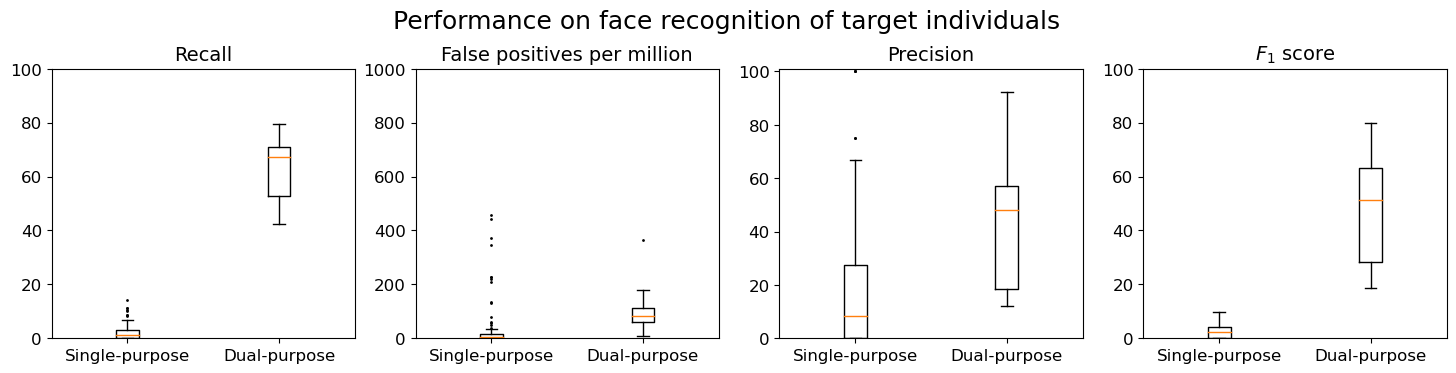

In [362]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18,3.5))
labels = ['Single-purpose', 'Dual-purpose']
markersize = 1
title_fontsize = 14
tick_fontsize = 12
suptitle_fontsize = 18
titles = ['Recall', 'False positives per million', 'Precision', '$F_1$ score']
metrics_spt = [recall_spt, fpr_spt, precision_spt, f1_spt]
metrics_dpt = [recall_dpt, fpr_dpt, precision_dpt, f1_dpt]
print('Single-purpose model face rec target performance')
print_median_iqr(metrics_spt, titles)
print('Dual-purpose model face rec target performance')
print_median_iqr(metrics_dpt, titles)
ylims = [[0, 100], [0, 1000], [0, 101], [0, 100]]
for i, (val1, val2) in enumerate(zip(metrics_spt, metrics_dpt)):
    axs[i].boxplot(
        [val1, val2],
        labels=labels,
        flierprops=dict(markersize=markersize))
    axs[i].set_title(titles[i], fontsize=title_fontsize)
    axs[i].set_ylim(ylims[i][0], ylims[i][1])
    axs[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
fig.suptitle('Performance on face recognition of target individuals', fontsize=suptitle_fontsize, y=1.05)
fig.savefig('fr-target-performance-boxplot.pdf', bbox_inches='tight')
plt.show()

# FR Performance on Non-targets

In [363]:
precision_spn, recall_spn, fpr_spn, f1_spn = analyse_secondary_task_performance(sp_models, non_target=True)
precision_dpn, recall_dpn, fpr_dpn, f1_dpn = analyse_secondary_task_performance(dp_models, non_target=True)

best_model.test_all_targets_single_purpose_120_1200_150_42.dill
best_model.test_all_targets_single_purpose_120_1200_150_42.dill
best_model.test_all_targets_single_purpose_120_1200_150_42.dill
best_model.test_all_targets_single_purpose_120_1200_150_42.dill
best_model.test_all_targets_single_purpose_120_1200_150_42.dill
best_model.test_all_targets_single_purpose_120_1200_150_42.dill
best_model.test_all_targets_single_purpose_120_1200_150_42.dill
best_model.test_all_targets_single_purpose_120_1200_150_42.dill
best_model.test_all_targets_single_purpose_120_1200_150_42.dill
best_model.test_all_targets_single_purpose_120_1200_150_42.dill


best_model.test_n000155_120_1200_150_42.dill
best_model.test_n002754_120_1200_150_42.dill
best_model.test_n003829_120_1200_150_42.dill
best_model.test_n004594_120_1200_150_42.dill
best_model.test_n004706_120_1200_150_42.dill
best_model.test_n005517_120_1200_150_42.dill
best_model.test_n006332_120_1200_150_42.dill
best_model.test_n006373_120_1200_150_42.dill
best_model.test_n006408_120_1200_150_42.dill
best_model.test_n009218_120_1200_150_42.dill


In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18,3.5))
labels = ['Single-purpose', 'Dual-purpose']
markersize = 1
title_fontsize = 14
tick_fontsize = 12
suptitle_fontsize = 18
titles = ['Recall', 'False positives per million', 'Precision', '$F_1$ score']
metrics_spn = [recall_spn, fpr_spn, precision_spn, f1_spn]
metrics_dpn = [recall_dpn, fpr_dpn, precision_dpn, f1_dpn]
print('Single-purpose model face rec non-target performance')
print_median_iqr(metrics_spn, titles)
print('Dual-purpose model face rec non-target performance')
print_median_iqr(metrics_dpn, titles)
ylims = [[0, 100], [0, 1500], [0, 101], [0, 100]]
for i, (val1, val2) in enumerate(zip(metrics_spn, metrics_dpn)):
    axs[i].boxplot(
        [val1, val2],
        labels=labels,
        flierprops=dict(markersize=markersize))
    axs[i].set_title(titles[i], fontsize=title_fontsize)
    axs[i].set_ylim(ylims[i][0], ylims[i][1])
    axs[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
axs[1].ticklabel_format(axis='y', scilimits=(2, 2))
fig.suptitle('Performance on face recognition of non-target individuals', fontsize=suptitle_fontsize, y=1.05)
fig.savefig('fr-non-target-performance-boxplot.pdf', bbox_inches='tight')
plt.show()

# False positives of images count in CSS

In [365]:
def analyse_fp_count(model_paths):
    """Analyse primary task performance."""
    data_paths = [f.path for m in model_paths for f in os.scandir(m) if 'fp_count' in f.name]
    print_model_names(data_paths)
    result = collections.defaultdict(list)
    for path in progress_bar(data_paths):
        with open(path, 'rb') as fp:
            data = dill.load(fp)
            if 'imagenet_fr_d' not in data:
                continue
            for db, val in data.items():
                if not isinstance(val, dict):
                    continue
                for q, fps in val.items():
                    result[f'{q}-{db}'].append(fps)
    return pd.DataFrame.from_dict(result, orient='columns')

In [366]:
dp_df = analyse_fp_count(dp_models)

dual-purpose-n000155-1m
dual-purpose-n002754-1m
dual-purpose-n003829-1m
dual-purpose-n004594-1m
dual-purpose-n004706-1m
dual-purpose-n005517-1m
dual-purpose-n006332-1m
dual-purpose-n006373-1m
dual-purpose-n006408-1m
dual-purpose-n009218-1m


In [239]:
print("False positive count for dual-purpose models")
print_median_iqr(
    [dp_df['fr_q-icd_d'], dp_df['fr_q-isc_fr_d'], dp_df['fr_q-imagenet_d'], dp_df['fr_q-imagenet_fr_d']],
    ['FR Q on ISC D', "FR Q on ISC D and D'", 'FR Q on Imagenet D', "FR Q on Imagent D and D'"]
)

False positive count for dual-purpose models
FR Q on ISC D: 47.5 $\pm$ 80.75
FR Q on ISC D and D': 82.5 $\pm$ 51.0
FR Q on Imagenet D: 7.5 $\pm$ 64.5
FR Q on Imagent D and D': 87.0 $\pm$ 53.25


In [246]:
sp_df = analyse_fp_count(sp_models)

single-purpose-1m-99999
single-purpose-1m-1
single-purpose-1m-12
single-purpose-1m-123
single-purpose-1m-1234
single-purpose-1m-12345


In [241]:
print("False positive count for single-purpose models")
print_median_iqr(
    [sp_df['fr_q-icd_d'], sp_df['fr_q-isc_fr_d'], sp_df['fr_q-imagenet_d'], sp_df['fr_q-imagenet_fr_d']],
    ['FR Q on ISC D', "FR Q on ISC D and D'", 'FR Q on Imagenet D', "FR Q on Imagent D and D'"]
)

False positive count for single-purpose models
FR Q on ISC D: 2.5396793146929335 $\pm$ 3.174599143366167
FR Q on ISC D and D': 205.396564575791 $\pm$ 237.61874588095756
FR Q on Imagenet D: 17.46029528851392 $\pm$ 6.0317383723957185
FR Q on Imagent D and D': 223.49177969297818 $\pm$ 244.60286399636317


# Performance on k-templates

In [174]:
def analyse_templates_performance(models):
    """Analyse templates performance."""
    data_paths = [f.path for m in models for f in os.scandir(m) if 'templates' in f.name]
    summary = collections.defaultdict(list)
    for x in data_paths:
        print(os.path.basename(x))
    for path in progress_bar(data_paths):
        with open(path, 'rb') as fp:
            data = dill.load(fp)
        target_set = data['target_set']
        for target in target_set:
            for k, prec, rec, f in zip(data['k'], data['precision'][target], data['recall'][target], data['fpr'][target]):
                summary[k].append((2 * prec * rec * 100) / (prec + rec + 1e-6))
    return summary

In [175]:
dp_data = analyse_templates_performance(dp_models)

best_model.templates_28.dill
best_model.templates_28.dill
best_model.templates_28.dill
best_model.templates_28.dill
best_model.templates_28.dill
best_model.templates_28.dill
best_model.templates_28.dill
best_model.templates_28.dill
best_model.templates_28.dill
best_model.templates_28.dill


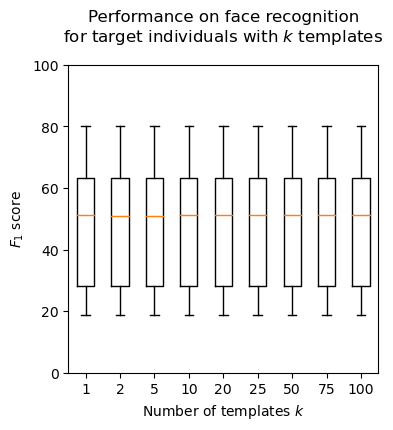

In [202]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
k_list = sorted(list(dp_data.keys()))
axs.boxplot(
    [dp_data[k] for k in k_list],
    labels=k_list,
    flierprops=dict(markersize=markersize))
# axs[i].set_title(titles[i], fontsize=title_fontsize)
axs.set_ylabel('$F_1$ score')
axs.set_xlabel('Number of templates $k$')
axs.set_title('Performance on face recognition\nfor target individuals with $k$ templates', y=1.05)
axs.set_ylim(0, 100)
fig.savefig('fr-target-performance-k-templates.pdf', bbox_inches='tight')
plt.show()

# Performance after generating collision images

In [211]:
def analyse_collision_performance(models):
    """Analyse templates performance."""
    data_paths = [f.path for m in models for f in os.scandir(m) if 'collision_stanford_dogs' in f.name]
    summary = {
        'precision': collections.defaultdict(list),
        'recall': collections.defaultdict(list),
        'fpr': collections.defaultdict(list),
        'f1': collections.defaultdict(list)
    }
    for x in data_paths:
        print(os.path.basename(x))
    for path in progress_bar(data_paths):
        with open(path, 'rb') as fp:
            data = dill.load(fp)
        target_set = data['target_set']
        for target in target_set:
            for idx, k in enumerate(data['k']):
                performance = data['collision_results'][target][idx]['performance']
                prec = performance['precision'] * 100
                rec = performance['recall'] * 100
                fpr = performance['fpr'] * 1e6
                f1 = (2 * prec * rec) / (prec + rec + 1e-6)
                summary['precision'][k].append(prec)
                summary['recall'][k].append(rec)
                summary['fpr'][k].append(fpr)
                summary['f1'][k].append(f1)
    return summary

In [212]:
dp_collision_perf = analyse_collision_performance(dp_models)

best_model.collision_stanford_dogs.dill
best_model.collision_stanford_dogs.dill
best_model.collision_stanford_dogs.dill
best_model.collision_stanford_dogs.dill
best_model.collision_stanford_dogs.dill
best_model.collision_stanford_dogs.dill
best_model.collision_stanford_dogs.dill
best_model.collision_stanford_dogs.dill
best_model.collision_stanford_dogs.dill
best_model.collision_stanford_dogs.dill


In [213]:
titles = ['Recall', 'False positives per million', 'Precision', '$F_1$ score']
metrics = [dp_collision_perf['recall'][1], dp_collision_perf['fpr'][1], dp_collision_perf['precision'][1], dp_collision_perf['f1'][1]]
print_median_iqr(metrics, titles)

Recall: 67.17543859649123 $\pm$ 18.321071955119507
False positives per million: 82.36115692290645 $\pm$ 52.349443403346434
Precision: 48.11832887063052 $\pm$ 38.24462104424085
$F_1$ score: 51.238201539357135 $\pm$ 35.04637705417081


# Example of collision images

In [274]:
def get_collision_images(models):
    """Analyse templates performance."""
    data_paths = [f.path for m in models for f in os.scandir(m) if 'collision_stanford_dogs' in f.name]
    summary = {
        'test_image_path': collections.defaultdict(list),
        'test_distances': collections.defaultdict(list),
        'original': collections.defaultdict(list),
        'modified': collections.defaultdict(list),
    }
    for x in data_paths:
        print(os.path.basename(x))
    random.seed(42)
    for path in progress_bar(data_paths):
        with open(path, 'rb') as fp:
            data = dill.load(fp)
        target_set = data['target_set']
        for target in target_set:
            for idx, k in enumerate(data['k']):
                result = data['collision_results'][target][idx]
                orig_distance = random.sample(list(result['distances_from_original_hash']), 1)[0]
                image_path = orig_distance[0]
                orig_img_distance = orig_distance[1][0]
                modified_img_distance = [x[1] for x in result['distances_from_collision_hash'] if x[0] == image_path][0][0]
                summary['test_image_path'][k].append(image_path)
                summary['test_distances'][k].append((orig_img_distance, modified_img_distance))
                summary['original'][k].append(result['orig_images'])
                summary['modified'][k].append(result['modified_images'])
    return summary

In [275]:
dp_images = get_collision_images(dp_models)

best_model.collision_stanford_dogs.dill
best_model.collision_stanford_dogs.dill
best_model.collision_stanford_dogs.dill
best_model.collision_stanford_dogs.dill
best_model.collision_stanford_dogs.dill
best_model.collision_stanford_dogs.dill
best_model.collision_stanford_dogs.dill
best_model.collision_stanford_dogs.dill
best_model.collision_stanford_dogs.dill
best_model.collision_stanford_dogs.dill


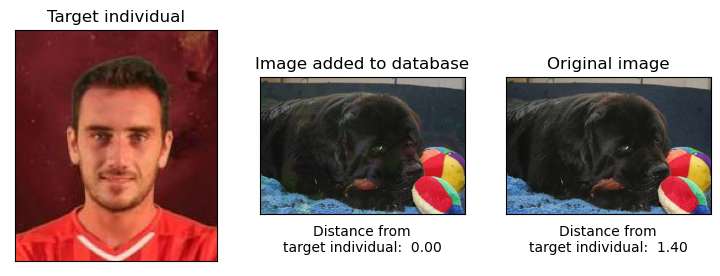

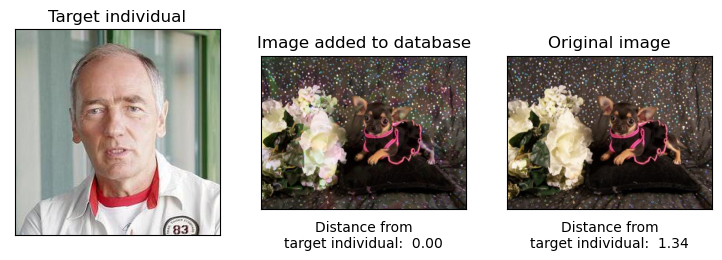

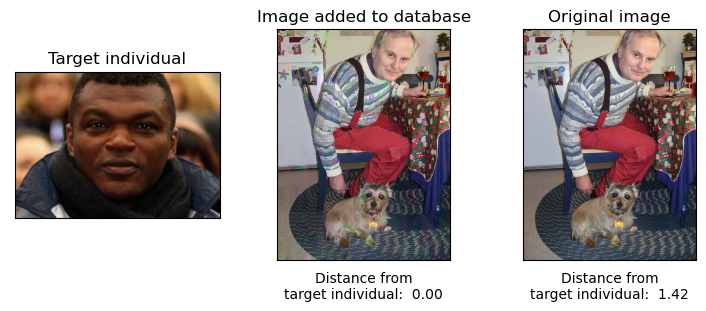

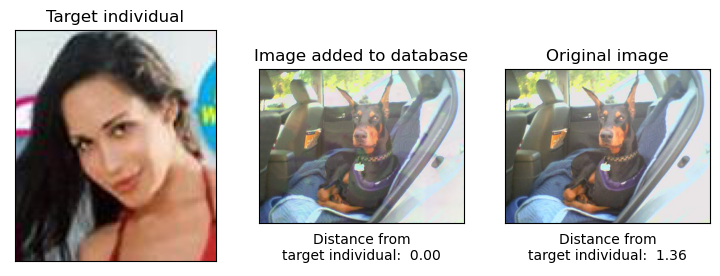

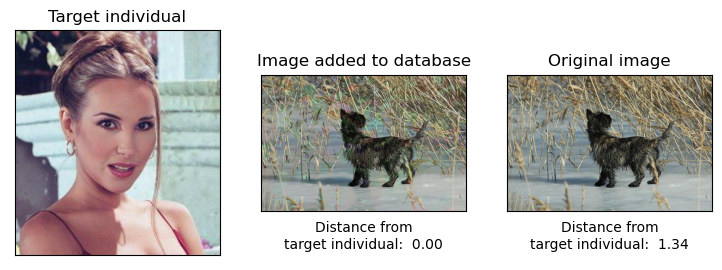

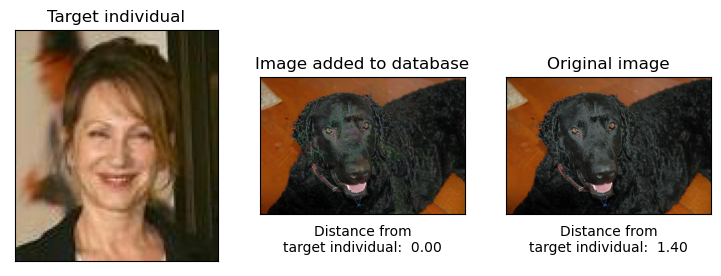

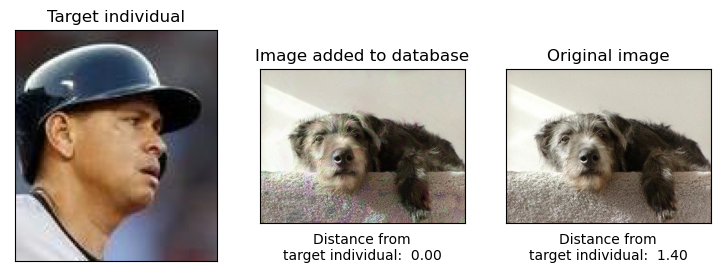

In [288]:
idx = 1
for test_img, test_dist, orig, mod in zip(
        dp_images['test_image_path'][1],
        dp_images['test_distances'][1],
        dp_images['original'][1],
        dp_images['modified'][1]
):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
    axs[0].imshow(Image.open(test_img))
    axs[0].set_title('Target individual')
    axs[1].imshow(mod[0])
    axs[1].set_title(f'Image added to database')
    axs[1].set_xlabel(f'Distance from\ntarget individual: {test_dist[1]: .2f}')
    axs[2].imshow(orig[0])
    axs[2].set_title(f'Original image')
    axs[2].set_xlabel(f'Distance from\ntarget individual: {test_dist[0]: .2f}')
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig(f'{idx}-collision.pdf', bbox_inches='tight')
    idx += 1

# Impact of number of training images

In [347]:
def analyse_impact_train_samples(models, train_samples_list):
    model_paths = {}
    f1_frt_list = []
    for num_images in train_samples_list:
        model_paths[num_images] = []
        for x in models:
            model_paths[num_images].append(f'{os.path.dirname(x)}-{num_images}')
        test_mu_ap, _, _ = get_primary_task_details(model_paths[num_images])
        prec_frt, recall_frt, fpr_frt, f1_frt = analyse_secondary_task_performance(
            model_paths[num_images], target=True)
        f1_frt_list.append(f1_frt)
        print_median_iqr([test_mu_ap, recall_frt, fpr_frt, prec_frt, f1_frt],
                         ['muAP', 'Recall_FRT', 'FPM_FRT', 'Precision_FRT', 'F1_FRT'])
    return f1_frt_list

In [348]:
f1_frt_list = analyse_impact_train_samples(dp_models, [25, 50, 75])

dual-purpose-n000155-1m-25
dual-purpose-n002754-1m-25
dual-purpose-n003829-1m-25
dual-purpose-n004594-1m-25
dual-purpose-n004706-1m-25
dual-purpose-n005517-1m-25
dual-purpose-n006332-1m-25
dual-purpose-n006373-1m-25
dual-purpose-n006408-1m-25
dual-purpose-n009218-1m-25


best_model.test_n000155_120_1200_150_42.dill
best_model.test_n002754_120_1200_150_42.dill
best_model.test_n003829_120_1200_150_42.dill
best_model.test_n004594_120_1200_150_42.dill
best_model.test_n004706_120_1200_150_42.dill
best_model.test_n005517_120_1200_150_42.dill
best_model.test_n006332_120_1200_150_42.dill
best_model.test_n006373_120_1200_150_42.dill
best_model.test_n006408_120_1200_150_42.dill
best_model.test_n009218_120_1200_150_42.dill


muAP: 59.06730249427 $\pm$ 0.42150322689477804
Recall_FRT: 34.73369051370942 $\pm$ 13.509487666034161
FPM_FRT: 65.28615741604781 $\pm$ 98.02684890877046
Precision_FRT: 29.6339202965709 $\pm$ 54.56007606294551
F1_FRT: 33.44961363408342 $\pm$ 33.08899532016484
dual-purpose-n000155-1m-50
dual-purpose-n002754-1m-50
dual-purpose-n003829-1m-50
dual-purpose-n004594-1m-50
dual-purpose-n004706-1m-50
dual-purpose-n005517-1m-50
dual-purpose-n006332-1m-50
dual-purpose-n006373-1m-50
dual-purpose-n006408-1m-50
dual-purpose-n009218-1m-50


best_model.test_n000155_120_1200_150_42.dill
best_model.test_n002754_120_1200_150_42.dill
best_model.test_n003829_120_1200_150_42.dill
best_model.test_n004594_120_1200_150_42.dill
best_model.test_n004706_120_1200_150_42.dill
best_model.test_n005517_120_1200_150_42.dill
best_model.test_n006332_120_1200_150_42.dill
best_model.test_n006373_120_1200_150_42.dill
best_model.test_n006408_120_1200_150_42.dill
best_model.test_n009218_120_1200_150_42.dill


muAP: 58.88608429818696 $\pm$ 0.6550743292515477
Recall_FRT: 54.30632630410655 $\pm$ 21.211252520819613
FPM_FRT: 53.54238029746233 $\pm$ 48.765742242573054
Precision_FRT: 48.494122218983776 $\pm$ 49.4688437306676
F1_FRT: 44.352128207815824 $\pm$ 31.807256990861674
dual-purpose-n000155-1m-75
dual-purpose-n002754-1m-75
dual-purpose-n003829-1m-75
dual-purpose-n004594-1m-75
dual-purpose-n004706-1m-75
dual-purpose-n005517-1m-75
dual-purpose-n006332-1m-75
dual-purpose-n006373-1m-75
dual-purpose-n006408-1m-75
dual-purpose-n009218-1m-75


best_model.test_n000155_120_1200_150_42.dill
best_model.test_n002754_120_1200_150_42.dill
best_model.test_n003829_120_1200_150_42.dill
best_model.test_n004594_120_1200_150_42.dill
best_model.test_n004706_120_1200_150_42.dill
best_model.test_n005517_120_1200_150_42.dill
best_model.test_n006332_120_1200_150_42.dill
best_model.test_n006373_120_1200_150_42.dill
best_model.test_n006408_120_1200_150_42.dill
best_model.test_n009218_120_1200_150_42.dill


muAP: 59.03470089476993 $\pm$ 0.5039549568911923
Recall_FRT: 62.269800022596314 $\pm$ 9.085461086412558
FPM_FRT: 94.53845155343663 $\pm$ 75.29047164361504
Precision_FRT: 47.9384203480589 $\pm$ 37.87363025018274
F1_FRT: 51.90045473699075 $\pm$ 30.927860741474078


# Performance after LSH

In [303]:
def analyse_lsh_performance(model_paths):
    """Analyse primary task performance."""
    data_paths = [f.path for m in model_paths for f in os.scandir(m) if 'lsh' in f.name]
    print_model_names(data_paths)
    test_mu_ap = []
    precision_ot = []
    recall_ot = []
    recall_frt = []
    precision_frt = []
    f1_frt = []
    fpr_frt = []
    recall_frn = []
    precision_frn = []
    f1_frn = []
    fpr_frn = []
    for path in progress_bar(data_paths):
        with open(path, 'rb') as fp:
            data = dill.load(fp)
        if data['primary_test'].average_precision < 0.4:
            continue
        test_mu_ap.append(data['primary_test'].average_precision * 100)
        tot, rot, pot = find_operating_point(
            data['primary_test'].thresholds,
            data['primary_test'].recalls,
            data['primary_test'].precisions,
            required_x = data['primary_val'].threshold_at_p90
        )
        precision_ot.append(pot * 100)
        recall_ot.append(rot * 100)
        metrics = data['secondary_test'].evaluate_performance()
        prec, rec, curr_f1, curr_fpr = get_prec_rec_fpr_f1(metrics, None, non_target=True)
        precision_frn.extend(prec)
        recall_frn.extend(rec)
        f1_frn.extend(curr_f1)
        fpr_frn.extend(curr_fpr)
        for idx, key in enumerate(metrics.target_precision):
            prec, rec, curr_f1, curr_fpr = get_prec_rec_fpr_f1(metrics, key, target=True)
            precision_frt.extend(prec)
            recall_frt.extend(rec)
            f1_frt.extend(curr_f1)
            fpr_frt.extend(curr_fpr)
    return {
        'mu_ap': test_mu_ap,
        'precision_icd': precision_ot,
        'recall_icd': recall_ot,
        'recall_frt': recall_frt,
        'fpr_frt': fpr_frt,
        'precision_frt': precision_frt,
        'f1_frt': f1_frt,
        'recall_frn': recall_frn,
        'fpr_frn': fpr_frn,
        'precision_frn': precision_frn,
        'f1_frn': f1_frn
    }

In [305]:
sp_lsh = analyse_lsh_performance(sp_models)
dp_lsh = analyse_lsh_performance(dp_models)

single-purpose-1m-9
single-purpose-1m-99
single-purpose-1m-999
single-purpose-1m-99999
single-purpose-1m-1
single-purpose-1m-12
single-purpose-1m-123
single-purpose-1m-12345


dual-purpose-n000155-1m
dual-purpose-n002754-1m
dual-purpose-n003829-1m
dual-purpose-n004594-1m
dual-purpose-n004706-1m
dual-purpose-n005517-1m
dual-purpose-n006332-1m
dual-purpose-n006373-1m
dual-purpose-n006408-1m
dual-purpose-n009218-1m


In [307]:
print("Single-purpose LSH Performance")
print_median_iqr(sp_lsh.values(), sp_lsh.keys())
print("Dual-purpose LSH Performance")
print_median_iqr(dp_lsh.values(), dp_lsh.keys())

Single-purpose LSH Performance
mu_ap: 48.68217074623832 $\pm$ 0.7935047396790935
precision_icd: 91.46713104048759 $\pm$ 0.9431546943145435
recall_icd: 42.52345777600319 $\pm$ 1.0980235575963277
recall_frt: 0.5263157894736842 $\pm$ 1.5465293668954996
fpr_frt: 30.452729397635864 $\pm$ 50.59339575951488
precision_frt: 0.6670783072750126 $\pm$ 2.540360873694207
f1_frt: 0.7639038814229141 $\pm$ 1.2945382982179705
recall_frn: 0.625 $\pm$ 1.4705882352941175
fpr_frn: 27.27971157097515 $\pm$ 48.84761463304588
precision_frn: 1.6666666666666667 $\pm$ 4.878048780487805
f1_frn: 0.9090904821489609 $\pm$ 1.900237221382236
Dual-purpose LSH Performance
mu_ap: 48.409863266669724 $\pm$ 0.8669957991650463
precision_icd: 91.13262086868599 $\pm$ 1.3033682874921055
recall_icd: 42.50349371131962 $\pm$ 0.5090836494310196
recall_frt: 66.24561403508773 $\pm$ 19.375388843165048
fpr_frt: 73.49699831410172 $\pm$ 45.15494789992736
precision_frt: 50.77888863055104 $\pm$ 39.570854978606796
f1_frt: 52.281990141159405 $

# Threshold variation performance

In [333]:
def analyse_performance_threshold_var(model_paths):
    """Analyse primary task performance."""
    data_paths = [f.path for m in model_paths for f in os.scandir(m) if 'threshold_variation' in f.name]
    print_model_names(data_paths)
    precision_lims = set()
    precision_icd = collections.defaultdict(list)
    recall_icd = collections.defaultdict(list)
    recall_frt = collections.defaultdict(list)
    precision_frt = collections.defaultdict(list)
    f1_frt = collections.defaultdict(list)
    fpr_frt = collections.defaultdict(list)
    recall_frn = collections.defaultdict(list)
    precision_frn = collections.defaultdict(list)
    f1_frn = collections.defaultdict(list)
    fpr_frn = collections.defaultdict(list)
    for path in progress_bar(data_paths):
        with open(path, 'rb') as fp:
            data = dill.load(fp)
        for tprec, test_metric in zip(data['precision_lims'], data['primary_test']):
            precision_lims.add(tprec)
            precision_icd[tprec].append(test_metric.precision * 100)
            recall_icd[tprec].append(test_metric.recall * 100)
        for tprec, test_metric in zip(data['precision_lims'], data['secondary_test']):
            metrics = test_metric.evaluate_performance()
            prec, rec, curr_f1, curr_fpr = get_prec_rec_fpr_f1(metrics, None, non_target=True)
            precision_frn[tprec].extend(prec)
            recall_frn[tprec].extend(rec)
            f1_frn[tprec].extend(curr_f1)
            fpr_frn[tprec].extend(curr_fpr)
            for idx, key in enumerate(metrics.target_precision):
                prec, rec, curr_f1, curr_fpr = get_prec_rec_fpr_f1(metrics, key, target=True)
                precision_frt[tprec].extend(prec)
                recall_frt[tprec].extend(rec)
                f1_frt[tprec].extend(curr_f1)
                fpr_frt[tprec].extend(curr_fpr)
    return {
        'precision_lims': precision_lims,
        'precision': precision_icd,
        'recall': recall_icd,
        'recall_frt': recall_frt,
        'fpr_frt': fpr_frt,
        'precision_frt': precision_frt,
        'f1_frt': f1_frt,
        'recall_frn': recall_frn,
        'fpr_frn': fpr_frn,
        'precision_frn': precision_frn,
        'f1_frn': f1_frn
    }

In [334]:
sp_thresh = analyse_performance_threshold_var(sp_models)
dp_thresh = analyse_performance_threshold_var(dp_models)

single-purpose-1m-9
single-purpose-1m-99
single-purpose-1m-999
single-purpose-1m-99999
single-purpose-1m-1
single-purpose-1m-12
single-purpose-1m-123
single-purpose-1m-1234
single-purpose-1m-12345


dual-purpose-n000155-1m
dual-purpose-n002754-1m
dual-purpose-n003829-1m
dual-purpose-n004594-1m
dual-purpose-n004706-1m
dual-purpose-n005517-1m
dual-purpose-n006332-1m
dual-purpose-n006373-1m
dual-purpose-n006408-1m
dual-purpose-n009218-1m


In [335]:
def print_thresh_summary(data):
    for tprec in sp_thresh['precision_lims']:
        print(f"Threshold precision: {tprec} ------------------")
        for key, val in data.items():
            if isinstance(val, dict):
                print_median_iqr([val[tprec]], [key])

print("Single-purpose models threshold performance ==========")
print_thresh_summary(sp_thresh)
print("Dual-purpose models threshold performance ============")
print_thresh_summary(dp_thresh)

Single-purpose models threshold performance ==========
Threshold precision: 0.95 ------------------
precision: 95.79375848032564 $\pm$ 0.6267758188620718
recall: 44.18047514473947 $\pm$ 1.2976642044320243
recall_frt: 0.0 $\pm$ 0.5882352941176471
fpr_frt: 0.0 $\pm$ 0.6344106895663549
precision_frt: 0.0 $\pm$ 7.142857142857142
f1_frt: 0.0 $\pm$ 1.1695906316473446
recall_frn: 0.0 $\pm$ 0.5235602094240838
fpr_frn: 0.0 $\pm$ 0.6344050549394777
precision_frn: 0.0 $\pm$ 50.0
f1_frn: 0.0 $\pm$ 1.036269419742812
Threshold precision: 0.99 ------------------
precision: 99.02439024390245 $\pm$ 0.21185023727227303
recall: 32.72110201637054 $\pm$ 1.2577360750648836
recall_frt: 0.0 $\pm$ 0.0
fpr_frt: 0.0 $\pm$ 0.0
precision_frt: 0.0 $\pm$ 0.0
f1_frt: 0.0 $\pm$ 0.0
recall_frn: 0.0 $\pm$ 0.0
fpr_frn: 0.0 $\pm$ 0.0
precision_frn: 0.0 $\pm$ 0.0
f1_frn: 0.0 $\pm$ 0.0
Dual-purpose models threshold performance ============
Threshold precision: 0.95 ------------------
precision: 95.38657691557793 $\pm$ 0.838